In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
%matplotlib inline
az.style.use("arviz-darkgrid")

from jax import numpy as jnp
from jax import lax
from jax.random import PRNGKey

import numpyro
from numpyro.infer import SVI, Predictive, ELBO
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoLaplaceApproximation
import numpyro.diagnostics as diag
import numpyro.distributions as dist

from causalgraphicalmodels import CausalGraphicalModel as CGM

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as OLS

In [2]:
url = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/WaffleDivorce.csv"
A = 'MedianAgeMarriage'
D = 'Divorce'
M = 'Marriage'
data = pd.read_csv(url, sep=';')[[M,A,D]]
data.head()

,Marriage,MedianAgeMarriage,Divorce
0,20.2,25.3,12.7
1,26.0,25.2,12.5
2,20.3,25.8,10.8
3,26.4,24.3,13.5
4,19.1,26.8,8.0


In [3]:
scalers = dict()
for col in [A,M,D]:
    data[col + "_origin"] = data[col]
    scalers[col] = StandardScaler(copy=False).fit(data[[col]])
    data[col] = scalers[col].transform(data[[col + "_origin"]])

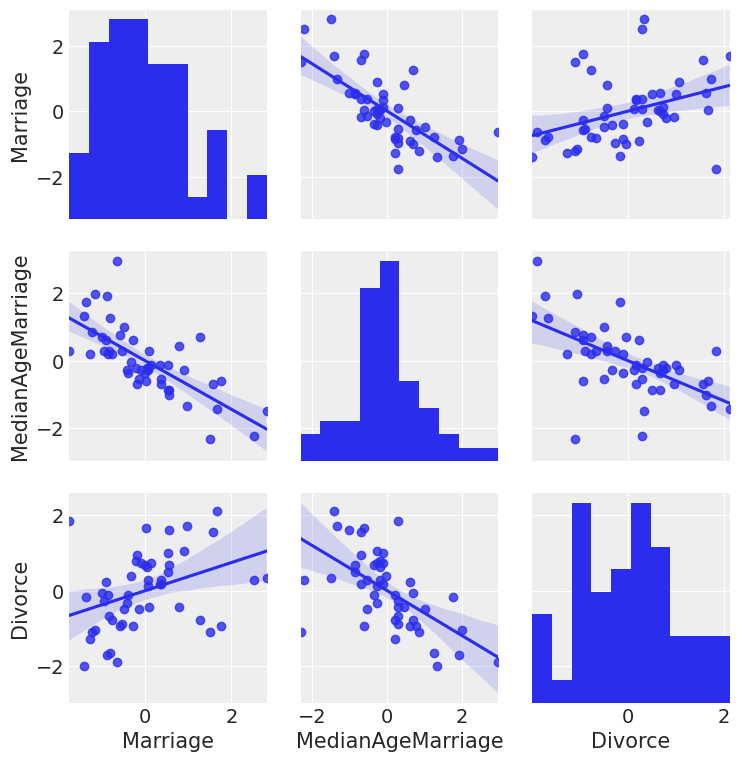

In [4]:
sns.pairplot(data[[M,A,D]], kind='reg');

# 5H1: is data consistent with M->A->D

In [5]:
def model(M, A=None, D=None):
    # M->A
    aA = numpyro.sample('aA', dist.Normal(0,0.2))
    bAM = numpyro.sample('bAM', dist.Normal(0, 0.5))
    muA = aA + bAM*M
    sigmaA = numpyro.sample('sigmaA', dist.Exponential(1))
    numpyro.deterministic('muA', muA)
    A = numpyro.sample('A', dist.Normal(muA, sigmaA), obs=A)
    # A-> D <- M
    aD = numpyro.sample('aD', dist.Normal(0,0.2))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    bM = numpyro.sample('bM', dist.Normal(0, 0.5))
    muD = aD + bA*A +bM*M
    sigmaD = numpyro.sample('sigmaD', dist.Exponential(1))
    numpyro.deterministic('muD', muD)
    numpyro.sample('D', dist.Normal(muD, sigmaD), obs=D)
    
guide = AutoLaplaceApproximation(model)
svi = SVI(model, guide, Adam(1), ELBO(),
          M=data[M].values, A=data[A].values, D=data[D].values)
state, loss = lax.scan(lambda x, i: svi.update(x), svi.init(PRNGKey(1)), np.zeros(1000))
param = svi.get_params(state)

In [6]:
post = guide.sample_posterior(PRNGKey(1), param, (1000,))
pred = Predictive(model, post, return_sites=['muA','A','muD','D'])

In [7]:
M_seq = np.linspace(data[M].min(), data[M].max(), 20)
A_seq = np.zeros(20)

In [8]:
post.update(pred(PRNGKey(2), M=M_seq, A=A_seq))

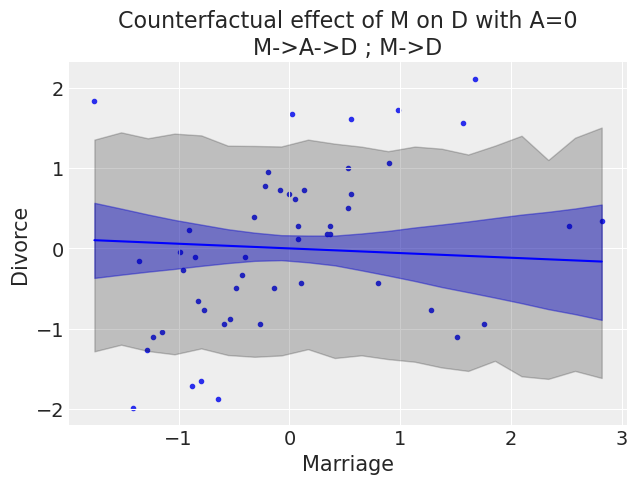

In [9]:
muD_mean = np.mean(post['muD'], 0)
muD_PI = np.percentile(post['muD'], q=(5.5, 94.5), axis=0)
D_PI = np.percentile(post['D'], q=(5.5, 94.5), axis=0)
az.plot_pair(data[[M, D]].to_dict(orient="list"))
plt.plot(M_seq, muD_mean, "b")
plt.fill_between(M_seq, muD_PI[0], muD_PI[1], color="b", alpha=0.4)
plt.fill_between(M_seq, D_PI[0], D_PI[1], color="k", alpha=0.2)
plt.title('Counterfactual effect of M on D with A=0\nM->A->D ; M->D');

# => M->D is spurious. So M->A->D is true

# 5H2: fit model with M->A->D. compute counterfactual effect with half M

In [10]:
def model2(M, A=None, D=None):
    # M->A
    aA = numpyro.sample('aA', dist.Normal(0,0.2))
    bM = numpyro.sample('bM', dist.Normal(0, 0.5))
    muA = aA + bM*M
    sigmaA = numpyro.sample('sigmaA', dist.Exponential(1))
    numpyro.deterministic('muA', muA)
    A = numpyro.sample('A', dist.Normal(muA, sigmaA), obs=A)
    # A-> D
    aD = numpyro.sample('aD', dist.Normal(0,0.2))
    bA = numpyro.sample('bA', dist.Normal(0, 0.5))
    muD = aD + bA*A
    sigmaD = numpyro.sample('sigmaD', dist.Exponential(1))
    numpyro.deterministic('muD', muD)
    numpyro.sample('D', dist.Normal(muD, sigmaD), obs=D)
    
guide2 = AutoLaplaceApproximation(model2)
svi2 = SVI(model2, guide2, Adam(1), ELBO(),
          M=data[M].values, A=data[A].values, D=data[D].values)
state2, loss2 = lax.scan(lambda x, i: svi2.update(x), svi2.init(PRNGKey(1)), np.zeros(1000))
param2 = svi2.get_params(state2)

In [11]:
post2 = guide2.sample_posterior(PRNGKey(1), param2, (1000,))
pred2 = Predictive(model2, post2, return_sites=['muD','D'])

In [12]:
M_seq2 = np.linspace(data[M+'_origin'].min(), data[M+'_origin'].max(), 20)
M_seq2 = np.ravel(scalers[M].transform(M_seq2.reshape(-1,1)))

In [13]:
post2.update(pred2(PRNGKey(2), M=M_seq2))

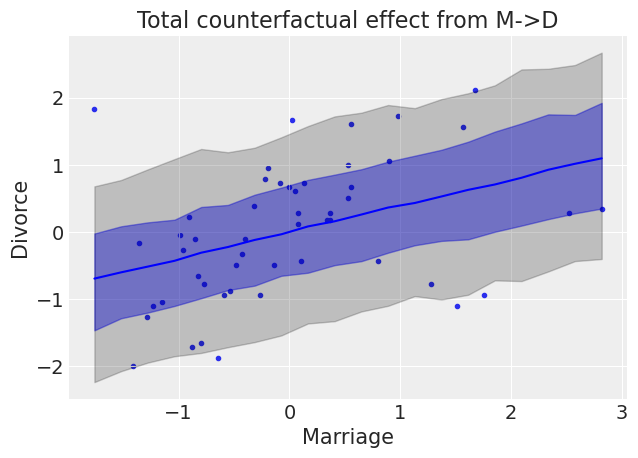

In [14]:
muD_mean2 = np.mean(post2['muD'], 0)
muD_PI2 = np.percentile(post2['muD'], q=(5.5, 94.5), axis=0)
D_PI2 = np.percentile(post2['D'], q=(5.5, 94.5), axis=0)

az.plot_pair(data[[M,D]].to_dict(orient="list"))
plt.plot(M_seq2, muD_mean2, "b")
plt.fill_between(M_seq2, muD_PI2[0], muD_PI2[1], color="b", alpha=0.4)
plt.fill_between(M_seq2, D_PI2[0], D_PI2[1], color="k", alpha=0.2)
plt.title('Total counterfactual effect from M->D');

In [15]:
data[M+'_half'] = scalers[M].transform(data[[M+"_origin"]]/2)

In [16]:
post2 = guide2.sample_posterior(PRNGKey(1), param2, (1000,))
pred2 = Predictive(model2, post2, return_sites=['D'])

np.mean(
    pred2(PRNGKey(2), M=data[M+"_half"].values)['D'] - \
        pred2(PRNGKey(2), M=data[M].values)['D'],
    axis=0)

DeviceArray([-1.0538815 , -1.3564808 , -1.0590986 , -1.3773497 ,
             -0.9964916 , -1.2260499 , -0.8921472 , -1.2051811 ,
             -0.9234504 , -0.8869297 , -1.1530087 , -1.2990915 ,
             -1.3460463 , -0.93388504, -1.0330126 , -1.1217053 ,
             -1.1530087 , -1.1582259 , -1.0747504 , -0.7043267 ,
             -0.95475376, -0.82432294, -0.8608436 , -0.7982369 ,
             -1.0069262 , -0.97040564, -0.9651884 , -1.0225778 ,
             -0.8712782 , -0.7721507 , -1.0643157 , -0.8764954 ,
             -1.0643158 , -1.3930016 , -0.88171244, -1.2417016 ,
             -0.98605734, -0.80867136, -0.7825852 , -0.9443193 ,
             -1.0486642 , -1.0121434 , -1.1217053 , -1.5443016 ,
             -0.8556264 , -1.0695331 , -1.116488  , -1.1582258 ,
             -0.89736444, -1.601691  ], dtype=float32)

In [17]:
f = lambda x: scalers[D].inverse_transform(np.array(x))
np.mean(
    f(pred2(PRNGKey(2), M=data[M+"_half"].values)['D']) - \
        f(pred2(PRNGKey(2), M=data[M].values)['D']),
    axis=0)

array([-1.8996358, -2.4450746, -1.9090384, -2.4826934, -1.7961905,
       -2.2099726, -1.6081058, -2.1723566, -1.6645334, -1.5987048,
       -2.078315 , -2.3416317, -2.4262683, -1.6833411, -1.8620195,
       -2.0218897, -2.078315 , -2.0877197, -1.9372517, -1.2695588,
       -1.7209575, -1.4858543, -1.5516833, -1.4388336, -1.8149984,
       -1.7491703, -1.7397664, -1.8432094, -1.5704911, -1.3918124,
       -1.9184455, -1.5798963, -1.9184453, -2.510905 , -1.5892991,
       -2.238185 , -1.7773808, -1.4576417, -1.4106205, -1.7021489,
       -1.8902317, -1.8244022, -2.0218897, -2.7836256, -1.5422788,
       -1.9278485, -2.012484 , -2.0877194, -1.6175113, -2.8870685],
      dtype=float32)

In [18]:
scalers[D].scale_

array([1.8025138])

# => By halving the `M` rate, `D` rate is reduce about 1 SD 

# 5H3: Milk example: M->N->K, M->K. compute counterfactual effect doubling M

In [19]:
url2 = r"https://raw.githubusercontent.com/fehiepsi/rethinking-numpyro/master/data/milk.csv"
M2 = 'mass'
N = 'neocortex.perc'
K = 'kcal.per.g'
data2 = pd.read_csv(url2, sep=';')[[M2,N,K]]
data2.dropna(inplace=True)
data2.head()

,mass,neocortex.perc,kcal.per.g
0,1.95,55.16,0.49
5,5.25,64.54,0.47
6,5.37,64.54,0.56
7,2.51,67.64,0.89
9,0.68,68.85,0.92


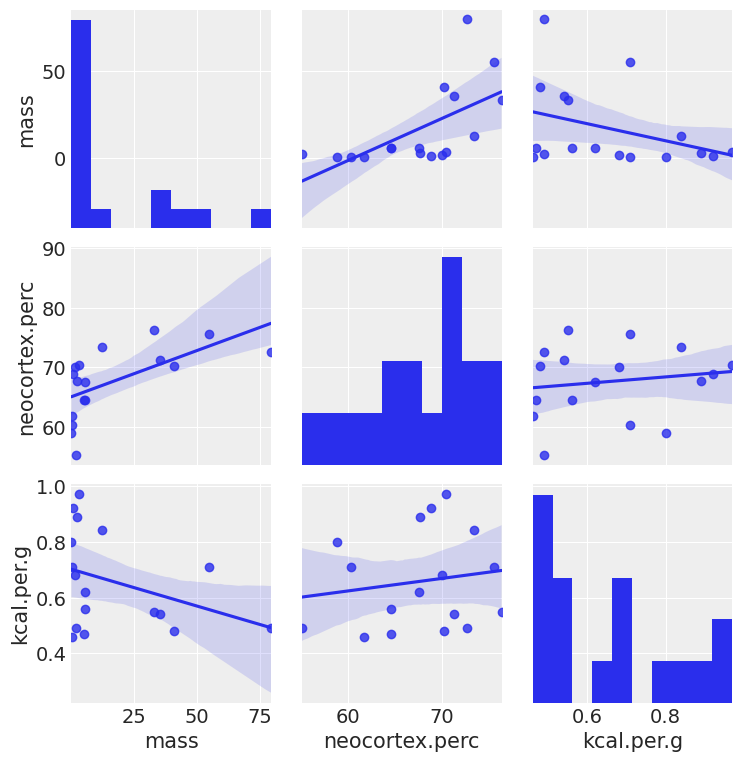

In [20]:
sns.pairplot(data2[[M2,N,K]], kind='reg');

In [21]:
scalers2 = dict()
for col in [M2,N,K]:
    data2[col + "_origin"] = data2[col]
    scalers2[col] = StandardScaler(copy=False).fit(data2[[col]])
    data2[col] = scalers2[col].transform(data2[[col + "_origin"]])

In [22]:
def model3(M, N=None, K=None):
    # M->N
    aN = numpyro.sample('aN', dist.Normal(0, 0.2))
    bM = numpyro.sample('bM', dist.Normal(0, 0.5))
    muN = aN + bM*M
    sigmaN = numpyro.sample('sigmaN', dist.Exponential(1))
    numpyro.deterministic('muN', muN)
    N = numpyro.sample('N', dist.Normal(muN, sigmaN), obs=N)
    
    # M,N -> K
    aK = numpyro.sample('aK', dist.Normal(0,0.2))
    bM2 = numpyro.sample('bM2', dist.Normal(0, 0.5))
    bN = numpyro.sample('bN', dist.Normal(0, 0.5))
    muK = aK + bM2*M + bN*N
    sigmaK = numpyro.sample('sigmaK', dist.Exponential(1))
    numpyro.deterministic('muK', muK)
    numpyro.sample('K', dist.Normal(muK, sigmaK), obs=K)
    
guide3 = AutoLaplaceApproximation(model3)
svi3 = SVI(model3, guide3, Adam(1), ELBO(),
           M=data2[M2].values,
           N=data2[N].values,
           K=data2[K].values)
init_state = svi3.init(PRNGKey(2))
state3, loss3 = lax.scan(lambda x, i: svi3.update(x), init_state, np.zeros(1000))
param3 = svi3.get_params(state3)

In [23]:
post3 = guide3.sample_posterior(PRNGKey(1), param3, (1000,))
pred3 = Predictive(model3, post3, return_sites=['muN','N','muK','K'])

In [24]:
M_seq3 = np.linspace(data2[M2+'_origin'].min(), data2[M2+'_origin'].max(), 20)
M_seq3 = np.ravel(scalers2[M2].transform(M_seq3.reshape(-1,1)))

In [25]:
post3.update(pred3(PRNGKey(2), M=M_seq3))

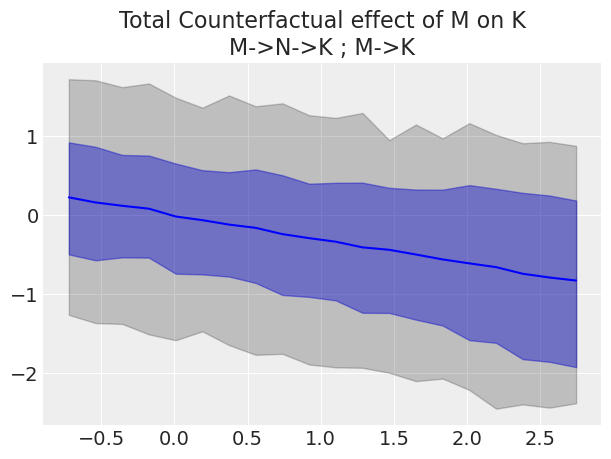

In [26]:
muK_mean = np.mean(post3['muK'], 0)
muK_PI = np.percentile(post3['muK'], q=(5.5, 94.5), axis=0)
K_PI = np.percentile(post3['K'], q=(5.5, 94.5), axis=0)
plt.plot(M_seq3, muK_mean, "b")
plt.fill_between(M_seq3, muK_PI[0], muK_PI[1], color="b", alpha=0.4)
plt.fill_between(M_seq3, K_PI[0], K_PI[1], color="k", alpha=0.2)
plt.title('Total Counterfactual effect of M on K\nM->N->K ; M->K');

In [27]:
post3 = guide3.sample_posterior(PRNGKey(1), param3, (1000,))
pred3 = Predictive(model3, post3, return_sites=['muN','N','muK','K'])
M_seq3 = np.linspace(data2[M2+'_origin'].min(), data2[M2+'_origin'].max(), 20)
M_seq3 = np.ravel(scalers2[M2].transform(M_seq3.reshape(-1,1)))
N_seq3 = np.zeros(20)

In [28]:
post3.update(pred3(PRNGKey(2), M=M_seq3, N=N_seq3))

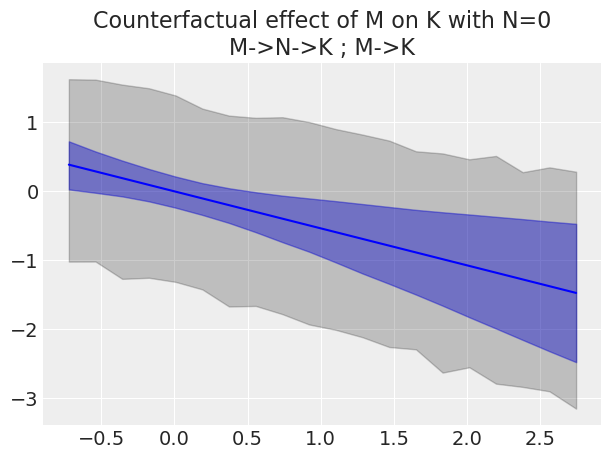

In [29]:
muK_mean = np.mean(post3['muK'], 0)
muK_PI = np.percentile(post3['muK'], q=(5.5, 94.5), axis=0)
K_PI = np.percentile(post3['K'], q=(5.5, 94.5), axis=0)
plt.plot(M_seq3, muK_mean, "b")
plt.fill_between(M_seq3, muK_PI[0], muK_PI[1], color="b", alpha=0.4)
plt.fill_between(M_seq3, K_PI[0], K_PI[1], color="k", alpha=0.2)
plt.title('Counterfactual effect of M on K with N=0\nM->N->K ; M->K');

In [30]:
data2[M2+'_x2'] = scalers2[M2].transform(data2[[M2+"_origin"]]*2)

In [31]:
post3 = guide3.sample_posterior(PRNGKey(1), param3, (1000,))
pred3 = Predictive(model3, post3, return_sites=['K'])

np.mean(
    pred3(PRNGKey(1), M=data2[M2+"_x2"].values)['K'] - \
        pred3(PRNGKey(1), M=data2[M2].values)['K'],
    axis=0)

DeviceArray([-0.02602862, -0.07007708, -0.07167882, -0.03350351,
             -0.00907666, -0.00160176, -0.00627357, -0.00427137,
             -0.02068942, -0.04324756, -0.16418058, -0.07167882,
             -0.47358757, -1.0602328 , -0.54379815, -0.4419527 ,
             -0.73347336], dtype=float32)

# => By doubling the mass, kcal.per.g is reduced by the amount of about 0.04 - 0.2 SD.